In [26]:
import time
import os
import sys
import math
import numpy as np
import cv2
import pandas as pd
import pyautogui as pa
from scipy.stats import binom_test
from matplotlib.markers import TICKDOWN
from matplotlib import rcParams
import datetime
from scipy.stats import norm, kstest, sem, ttest_ind
from numpy.polynomial import polynomial
import imageio
from scipy.fft import fft
from scipy.signal import coherence, correlate, csd
import networkx as nx
import matplotlib.pyplot as plt

from lib.auto_GUI.auto_GUI_base import AutoGUIBase
from lib.auto_GUI.auto_PhotoZ import AutoPhotoZ
from lib.analysis.laminar_dist import *
from lib.file.ROI_reader import ROIFileReader
from lib.analysis.cell_roi import OverlapCounterROI
from lib.analysis.baseline_correction import BaselineCorrection

In [27]:
data_dir = "C:/Users/jjudge3/Desktop/Data/mm_full_pipeline_targets/PPR_GABAzine_low_stim/"
catalog_csv = data_dir + 'ppr_catalog_backup.csv'
export_csv = data_dir + 'export_summary_backup.csv'

In [28]:
# load csv files
catalog_df = pd.read_csv(catalog_csv)
catalog_df = pd.DataFrame(catalog_df)
catalog_df

,zda_file,pulse1_start,pulse1_width,pulse2_start,pulse2_width,baseline_start,baseline_width,IPI,Notes,Stim_Current
0,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,316,37,356.0,37.0,316,240,20,"ACSF, PPR",50
1,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,316,37,NaN,NaN,316,200,20,"ACSF, Control",50
2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,116,37,356.0,37.0,116,440,120,"ACSF, PPR",50
3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,216,37,356.0,37.0,216,340,70,"ACSF, PPR",50
4,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,216,37,NaN,NaN,216,200,70,"ACSF, Control",50
5,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,316,37,356.0,37.0,316,240,20,"GABAzine, PPR",50
6,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,316,37,NaN,NaN,316,200,20,"GABAzine, Control",50
7,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,216,37,356.0,37.0,216,340,70,"GABAzine, PPR",50
8,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,216,37,NaN,NaN,216,200,70,"GABAzine, Control",50
9,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,116,37,356.0,37.0,116,440,120,"GABAzine, PPR",50


In [29]:
export_df = pd.read_csv(export_csv)
export_df = pd.DataFrame(export_df)
export_df  # home barrels are ROI 1, neighbor barrels are ROI 2

,ROI,amp,snr,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace,trace_non_polyfit,amp_array
0,1,0.781263,0.781263,2.142010e+01,2.311120,53.782288,34.221402,1_rois pulse1,9-27-24,1,1,2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
1,2,0.298859,0.298859,2.116100e+01,2.285160,34.711111,15.371429,1_rois pulse1,9-27-24,1,1,2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
2,1,0.036448,1.474530,2.803430e+01,-56.265100,53.782288,34.221402,1_rois pulse1,9-27-24,1,1,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
3,2,0.036735,1.626440,2.743600e+01,-55.072600,34.711111,15.371429,1_rois pulse1,9-27-24,1,1,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
4,1,0.000000,0.000000,0.000000e+00,-51.921700,53.782288,34.221402,1_rois pulse2,9-27-24,1,1,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2,0.665969,4.749990,6.167360e+01,14.050100,18.638710,39.619355,2_rois pulse1,9-27-24,2,2,5,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
70,1,0.162282,1.318760,2.547300e+01,6.773800,47.400943,33.400943,2_rois pulse1,9-27-24,2,2,6,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
71,2,0.208214,1.865440,1.909330e+01,-38.272300,18.638710,39.619355,2_rois pulse1,9-27-24,2,2,6,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...
72,1,0.057012,0.463298,-1.816620e-301,0.876492,47.400943,33.400943,2_rois pulse2,9-27-24,2,2,6,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...


In [30]:
# first, look up metadata in catalog_df and append to export_df
def read_dat_trace_file(filename):
    data_arr = pd.read_csv(filename,
                                 sep='\t',
                                 header=0)  # change me to traces?
    data_arr = data_arr.apply(pd.to_numeric, errors='coerce')
    return data_arr

def format_date(date, input_format="%m/%d/%Y", format="%m-%d-%y"):
    try:
        date = datetime.datetime.strptime(date, input_format)
        return date.strftime(format)
    except:
        return date

def format_zda(slic, loc, rec):
    """ pad to ss_ll_rr """
    slic = str(slic).zfill(2)
    loc = str(loc).zfill(2)
    rec = str(rec).zfill(2)
    return slic + '_' + loc + '_' + rec

for df in [export_df]:
    append_columns = {'ipi': [], 'drug' : [], 'num_pulses': [], "Stim_Current": [] }
    for index, row in df.iterrows():
        date = row['Date']    
        slic = row['Slice']
        location = row['Location']
        recording = row['Recording']
        file_formatted_date = format_date(date)
        zda_id = format_zda(row['Slice'], row['Location'], row['Recording'])

        # look up zda file in catalog
        zda_row = catalog_df.loc[(catalog_df['zda_file'].str.contains(file_formatted_date)) &
                                (catalog_df['zda_file'].str.contains(zda_id))]
        if len(zda_row) == 0:
            print(f"Could not find zda file for {file_formatted_date} {zda_id}")
            continue

        append_columns['ipi'].append(zda_row['IPI'].values[0])
        drug, num_pulses = zda_row['Notes'].values[0].split(',')
        stim_current = zda_row['Stim_Current'].values[0]
        append_columns['drug'].append(drug)
        append_columns['num_pulses'].append(num_pulses)
        append_columns['Stim_Current'].append(stim_current)

    # append columns to export_df
    for key, value in append_columns.items():
        df[key] = value
export_df

,ROI,amp,snr,latency,halfwidth,X_Center,Y_Center,ROI_Set,Date,Slice,Location,Recording,trace,trace_non_polyfit,amp_array,ipi,drug,num_pulses,Stim_Current
0,1,0.781263,0.781263,2.142010e+01,2.311120,53.782288,34.221402,1_rois pulse1,9-27-24,1,1,2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,20,ACSF,PPR,50
1,2,0.298859,0.298859,2.116100e+01,2.285160,34.711111,15.371429,1_rois pulse1,9-27-24,1,1,2,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,20,ACSF,PPR,50
2,1,0.036448,1.474530,2.803430e+01,-56.265100,53.782288,34.221402,1_rois pulse1,9-27-24,1,1,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,20,ACSF,Control,50
3,2,0.036735,1.626440,2.743600e+01,-55.072600,34.711111,15.371429,1_rois pulse1,9-27-24,1,1,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,20,ACSF,Control,50
4,1,0.000000,0.000000,0.000000e+00,-51.921700,53.782288,34.221402,1_rois pulse2,9-27-24,1,1,3,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,20,ACSF,Control,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,2,0.665969,4.749990,6.167360e+01,14.050100,18.638710,39.619355,2_rois pulse1,9-27-24,2,2,5,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,120,GABAzine,PPR,20
70,1,0.162282,1.318760,2.547300e+01,6.773800,47.400943,33.400943,2_rois pulse1,9-27-24,2,2,6,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,120,GABAzine,Control,20
71,2,0.208214,1.865440,1.909330e+01,-38.272300,18.638710,39.619355,2_rois pulse1,9-27-24,2,2,6,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,120,GABAzine,Control,20
72,1,0.057012,0.463298,-1.816620e-301,0.876492,47.400943,33.400943,2_rois pulse2,9-27-24,2,2,6,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,C:/Users/jjudge3/Desktop/Data/mm_full_pipeline...,120,GABAzine,Control,20


Date 9-27-24 Slice 1 Location 1 Recording 2
IPI 20 Drug ACSF ROI 1 stim_current 50
Trace Sub Dist: 0.03245551247374779


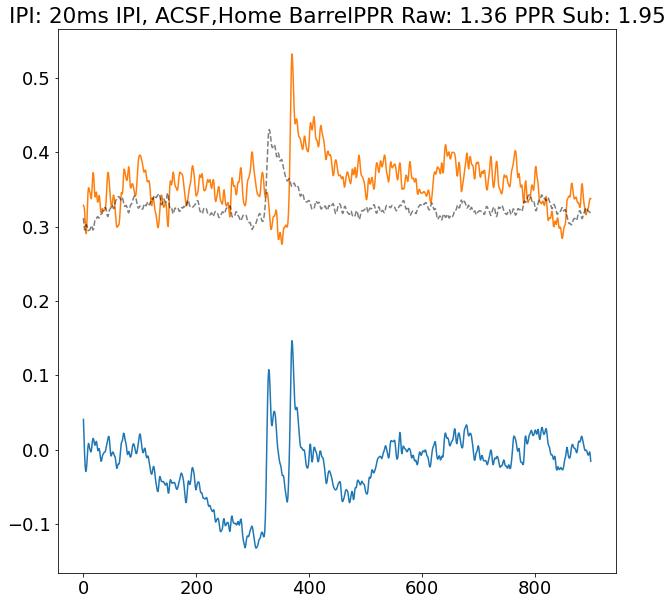

Date 9-27-24 Slice 1 Location 1 Recording 2
IPI 20 Drug ACSF ROI 2 stim_current 50
Trace Sub Dist: 0.03656603401781147


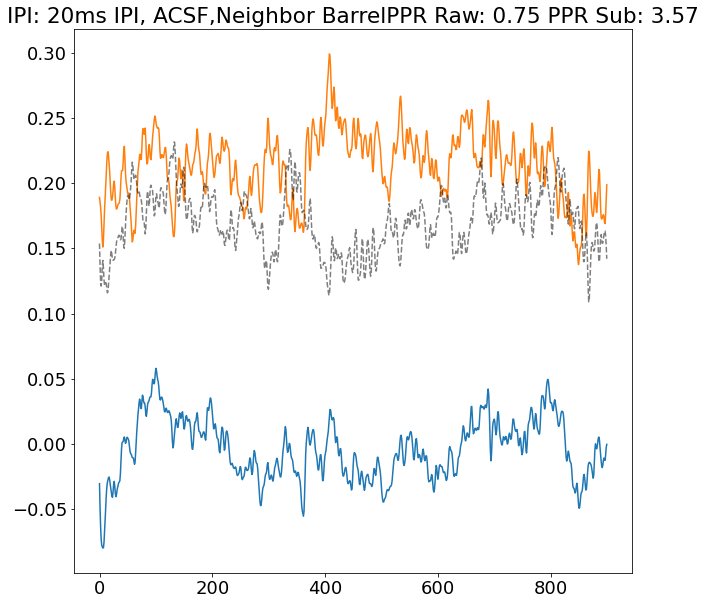

Date 9-27-24 Slice 2 Location 1 Recording 7
IPI 20 Drug ACSF ROI 1 stim_current 20
Trace Sub Dist: 0.07003336110072624


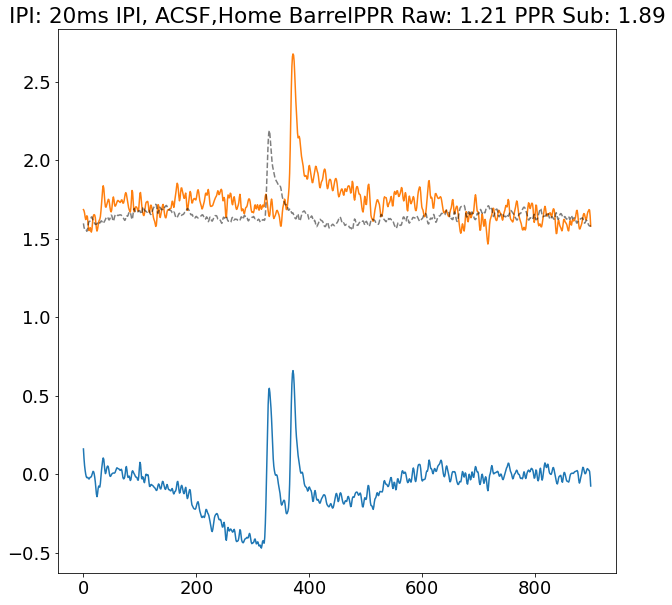

Date 9-27-24 Slice 2 Location 1 Recording 7
IPI 20 Drug ACSF ROI 2 stim_current 20
Trace Sub Dist: 0.07589628381177528


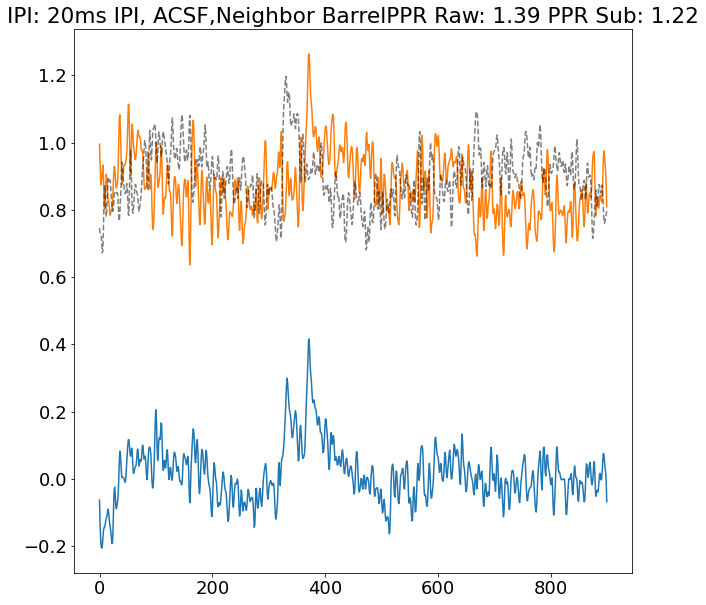

Date 9-27-24 Slice 1 Location 2 Recording 1
IPI 20 Drug GABAzine ROI 1 stim_current 50
Trace Sub Dist: 0.05126056951102991


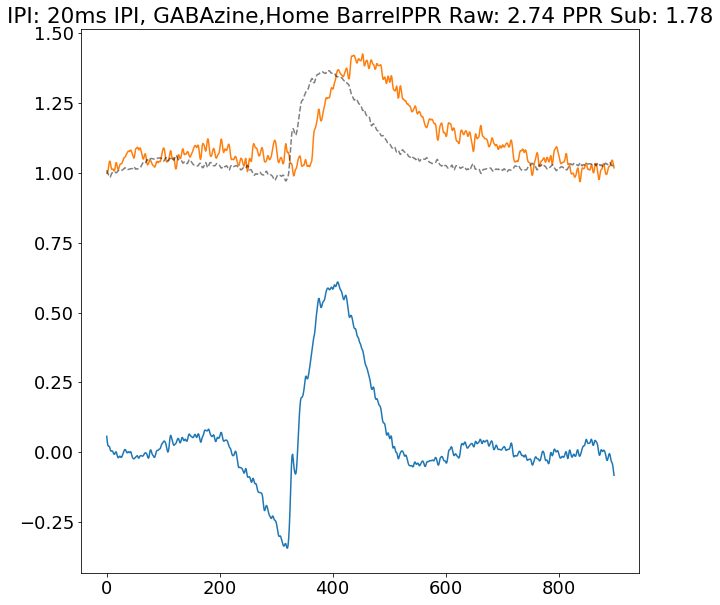

Date 9-27-24 Slice 1 Location 2 Recording 1
IPI 20 Drug GABAzine ROI 2 stim_current 50
Trace Sub Dist: 0.024142265655683916


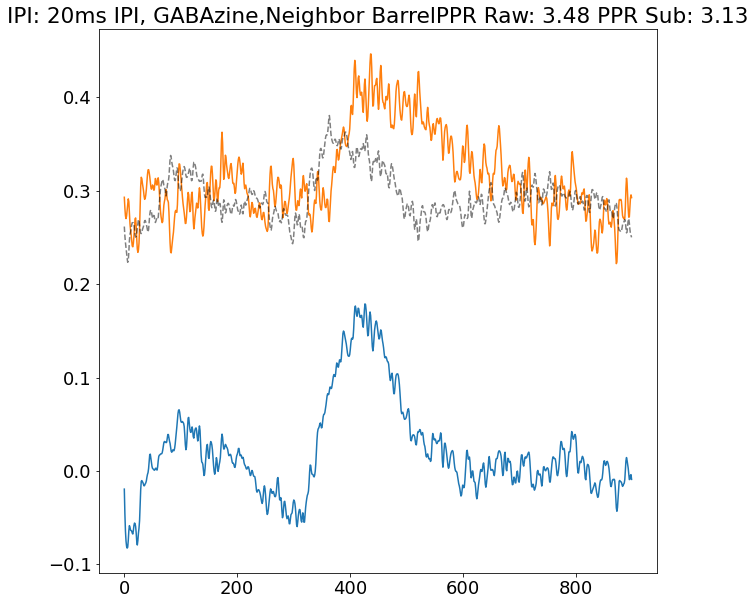

Date 9-27-24 Slice 1 Location 3 Recording 1
IPI 20 Drug GABAzine ROI 1 stim_current 20
Trace Sub Dist: 0.09018013361583535


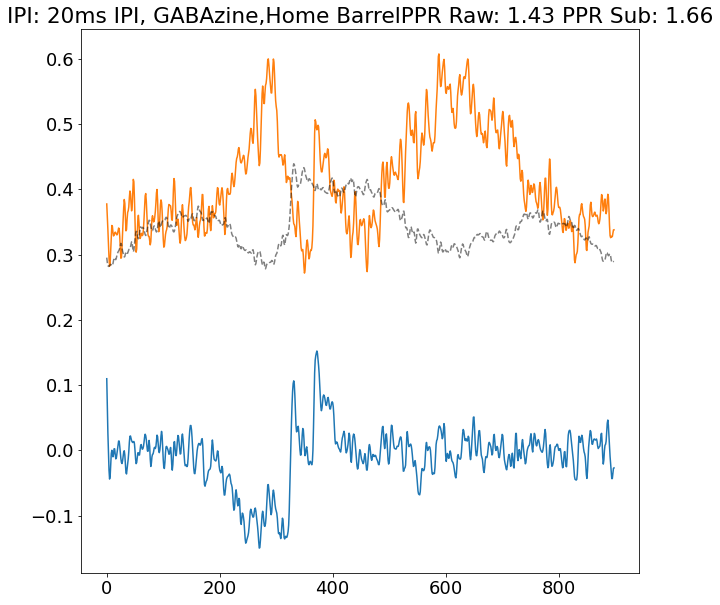

Date 9-27-24 Slice 1 Location 3 Recording 1
IPI 20 Drug GABAzine ROI 2 stim_current 20
Trace Sub Dist: 0.04823272001932013


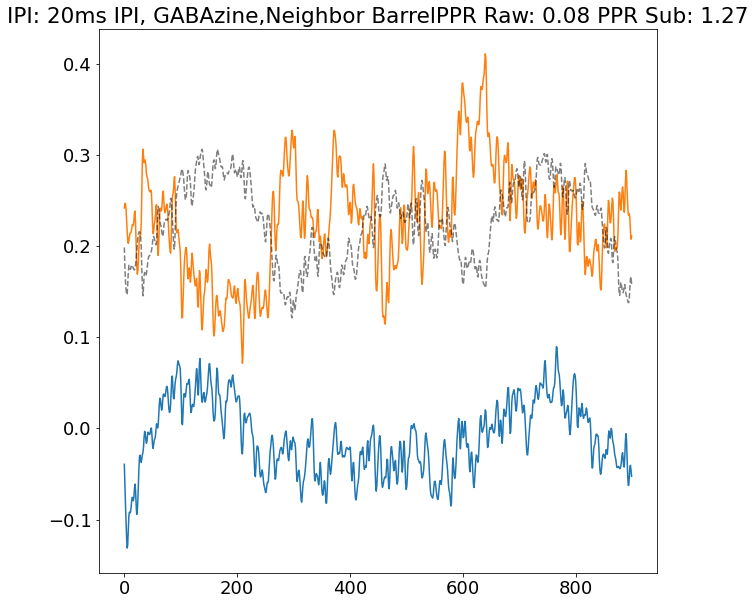

Missing PPR or Control trace for IPI 20 Drug GABAzine ROI 1
Date 9-27-24 Slice 2 Location 2 Recording 2
IPI 20 Drug GABAzine ROI 1 stim_current 20
PPR Trace


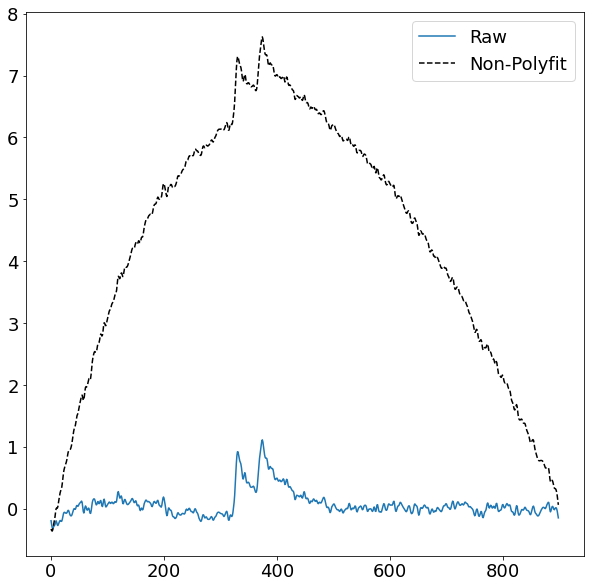

Missing PPR or Control trace for IPI 20 Drug GABAzine ROI 2
Date 9-27-24 Slice 2 Location 2 Recording 2
IPI 20 Drug GABAzine ROI 2 stim_current 20
PPR Trace


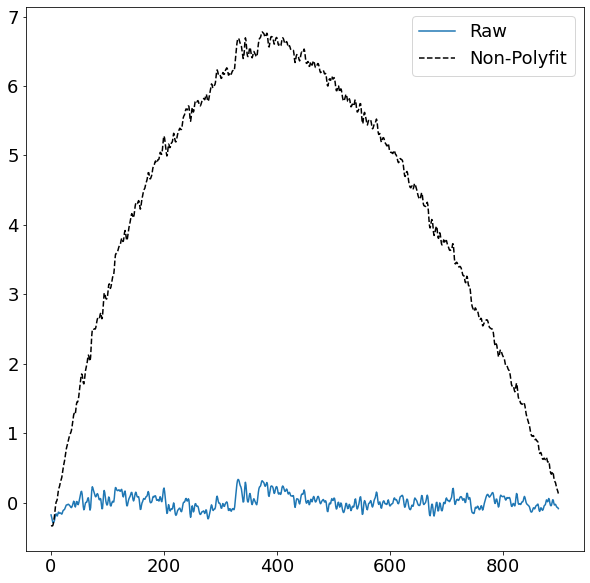

Missing PPR or Control trace for IPI 120 Drug ACSF ROI 1
Date 9-27-24 Slice 1 Location 1 Recording 4
IPI 120 Drug ACSF ROI 1 stim_current 50
PPR Trace


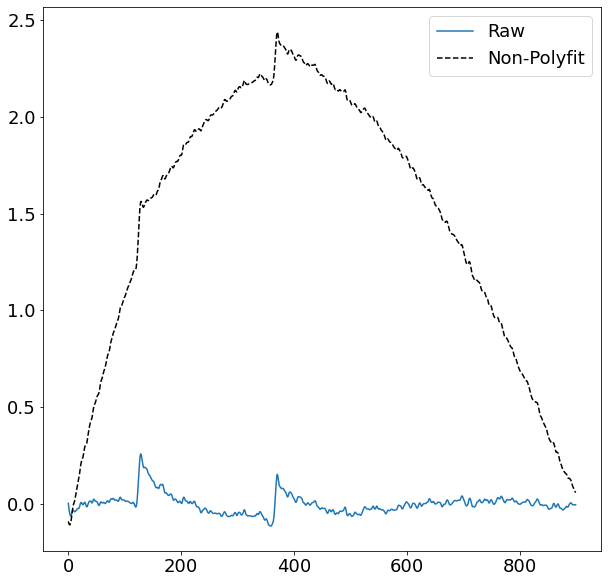

Missing PPR or Control trace for IPI 120 Drug ACSF ROI 2
Date 9-27-24 Slice 1 Location 1 Recording 4
IPI 120 Drug ACSF ROI 2 stim_current 50
PPR Trace


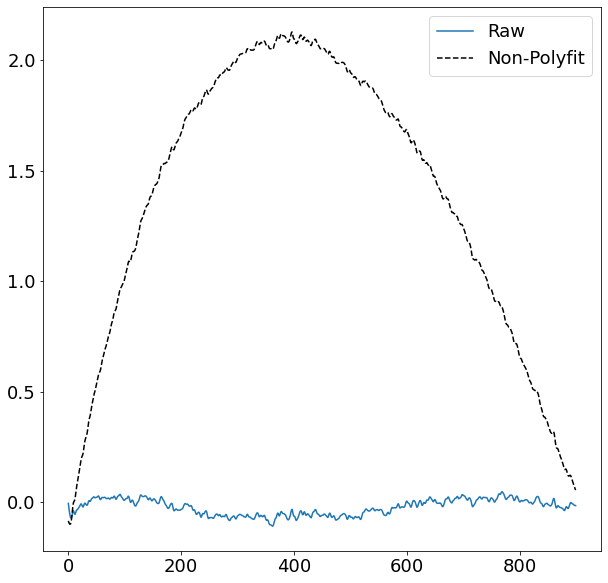

Date 9-27-24 Slice 2 Location 1 Recording 2
IPI 120 Drug ACSF ROI 1 stim_current 20
Trace Sub Dist: 0.039718203051625225


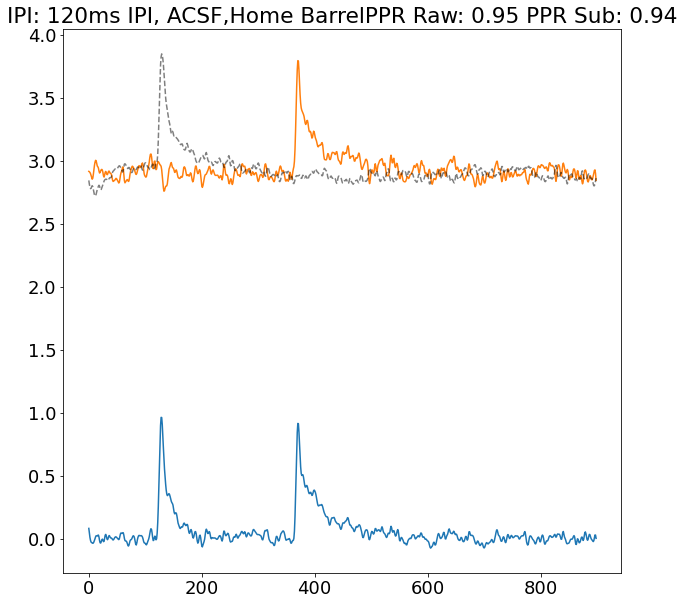

Date 9-27-24 Slice 2 Location 1 Recording 2
IPI 120 Drug ACSF ROI 2 stim_current 20
Trace Sub Dist: 0.05258699406829787


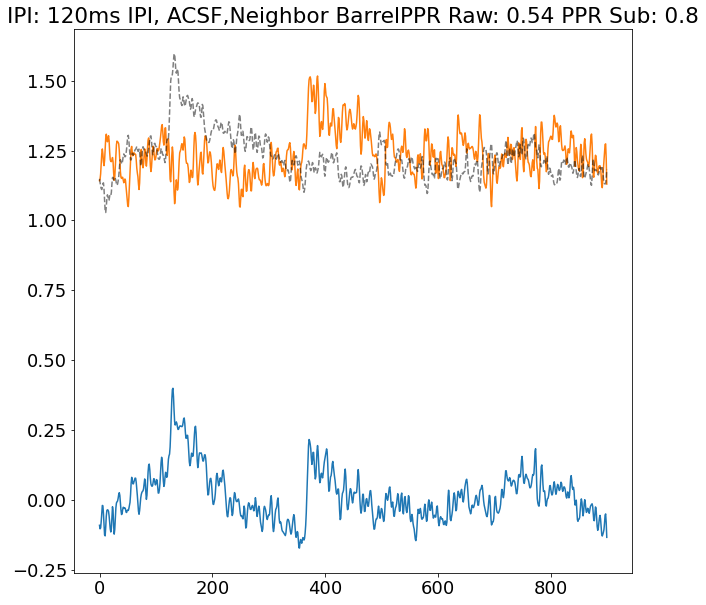

Date 9-27-24 Slice 1 Location 2 Recording 6
IPI 120 Drug GABAzine ROI 1 stim_current 50
Trace Sub Dist: 0.1763459928053144


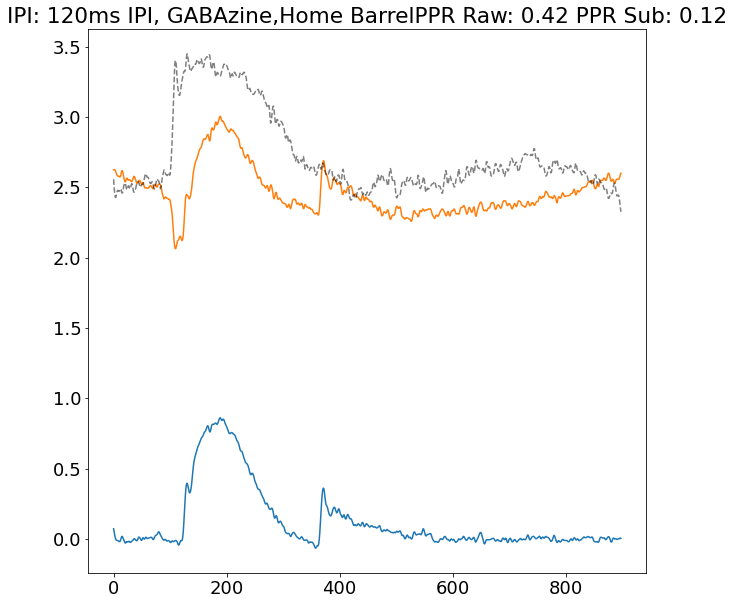

Date 9-27-24 Slice 1 Location 2 Recording 6
IPI 120 Drug GABAzine ROI 2 stim_current 50
Trace Sub Dist: 0.04099542839285144


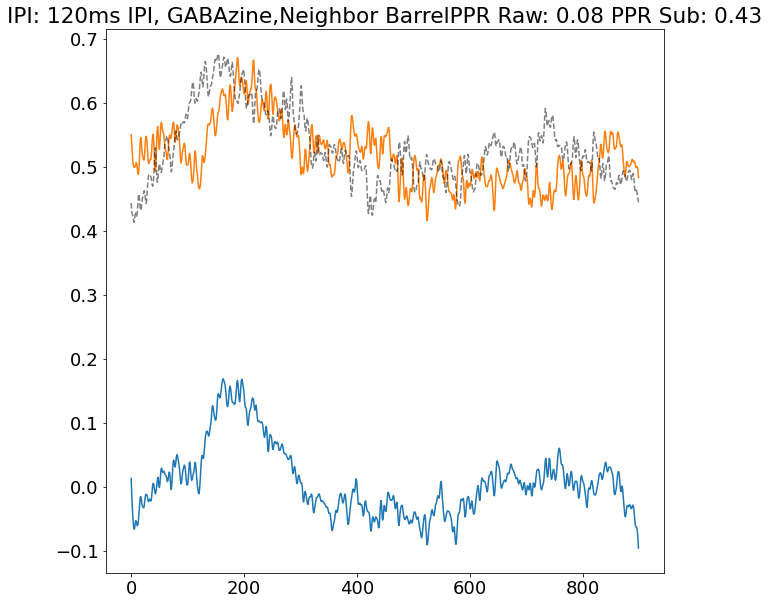

Missing PPR or Control trace for IPI 120 Drug GABAzine ROI 1
Date 9-27-24 Slice 1 Location 3 Recording 4
IPI 120 Drug GABAzine ROI 1 stim_current 20
PPR Trace


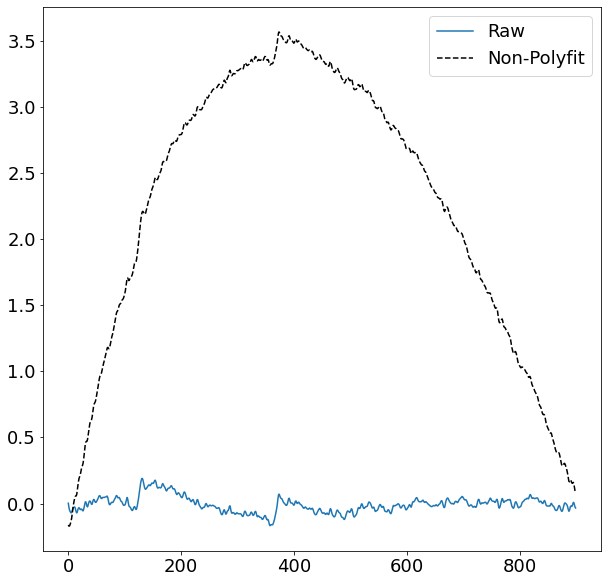

Missing PPR or Control trace for IPI 120 Drug GABAzine ROI 2
Date 9-27-24 Slice 1 Location 3 Recording 4
IPI 120 Drug GABAzine ROI 2 stim_current 20
PPR Trace


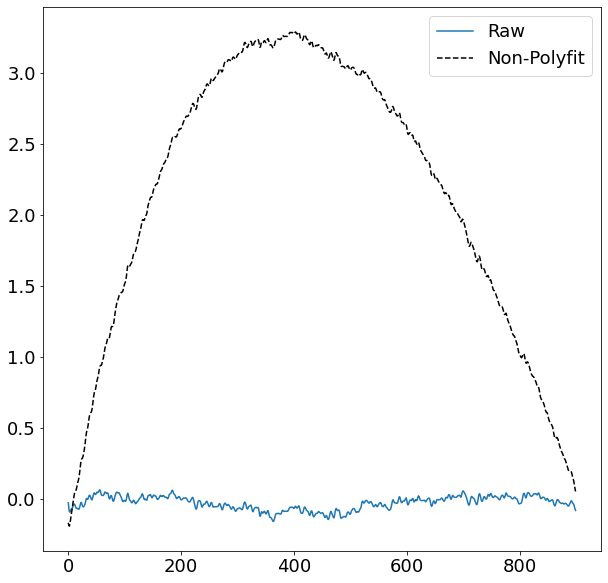

Date 9-27-24 Slice 2 Location 2 Recording 5
IPI 120 Drug GABAzine ROI 1 stim_current 20
Trace Sub Dist: 0.09962194171977336


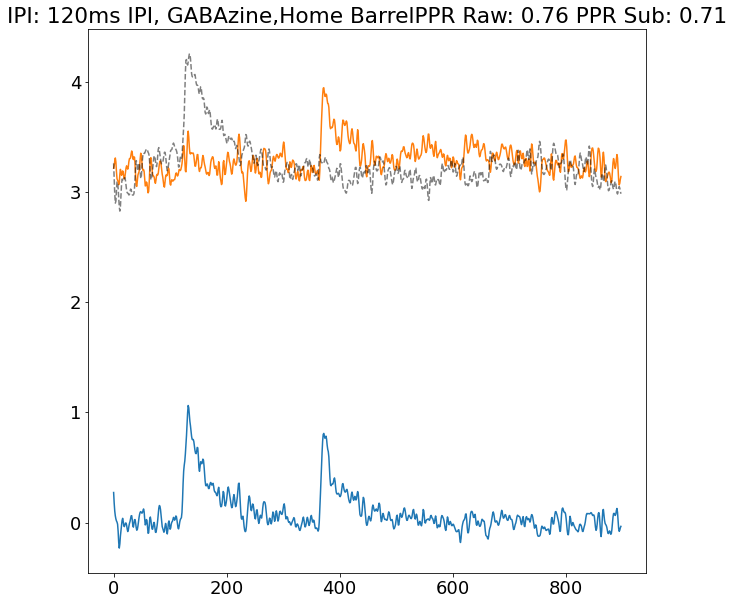

Date 9-27-24 Slice 2 Location 2 Recording 5
IPI 120 Drug GABAzine ROI 2 stim_current 20
Trace Sub Dist: 0.13067833178569901


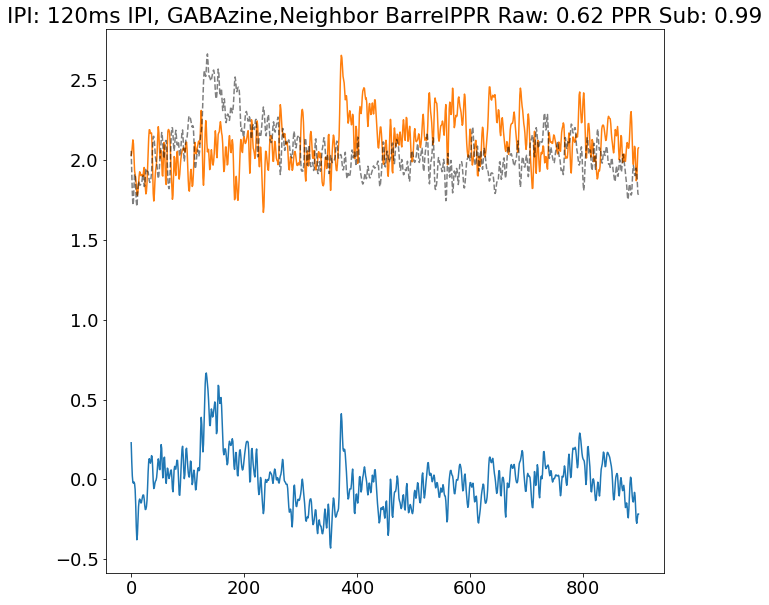

Date 9-27-24 Slice 1 Location 1 Recording 6
IPI 70 Drug ACSF ROI 1 stim_current 50
Trace Sub Dist: 0.020406251555527374


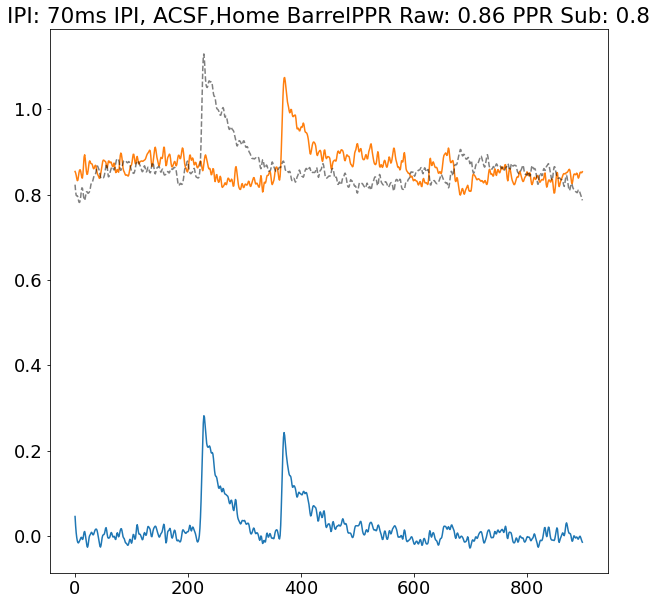

Date 9-27-24 Slice 1 Location 1 Recording 6
IPI 70 Drug ACSF ROI 2 stim_current 50
Trace Sub Dist: 0.02084817666673919


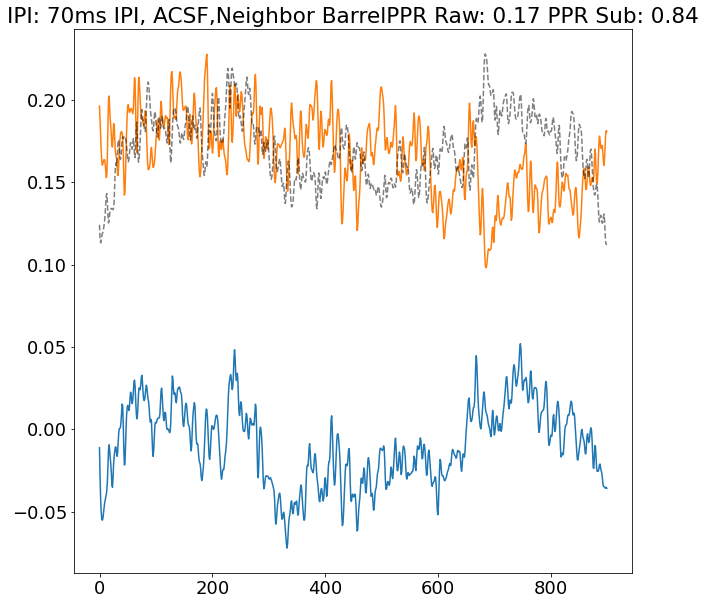

Date 9-27-24 Slice 2 Location 1 Recording 4
IPI 70 Drug ACSF ROI 1 stim_current 20
Trace Sub Dist: 0.051795017040616814


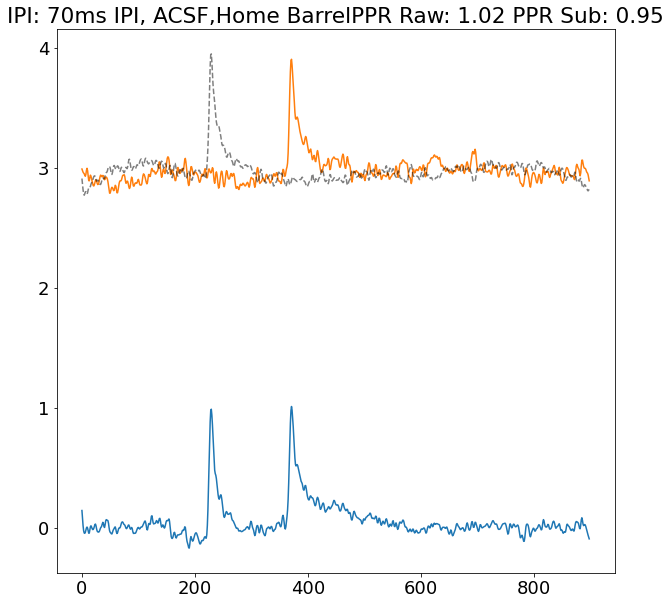

Date 9-27-24 Slice 2 Location 1 Recording 4
IPI 70 Drug ACSF ROI 2 stim_current 20
Trace Sub Dist: 0.09614153860724615


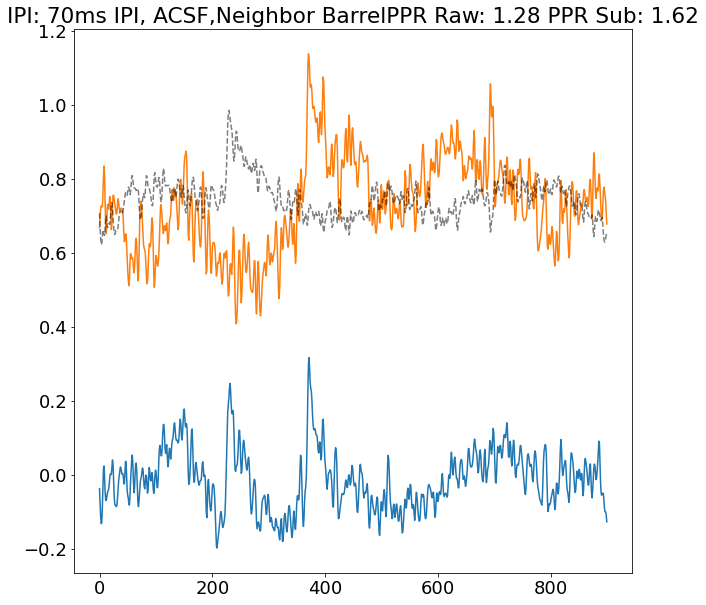

Date 9-27-24 Slice 1 Location 2 Recording 3
IPI 70 Drug GABAzine ROI 1 stim_current 50
Trace Sub Dist: 0.026703238053786982


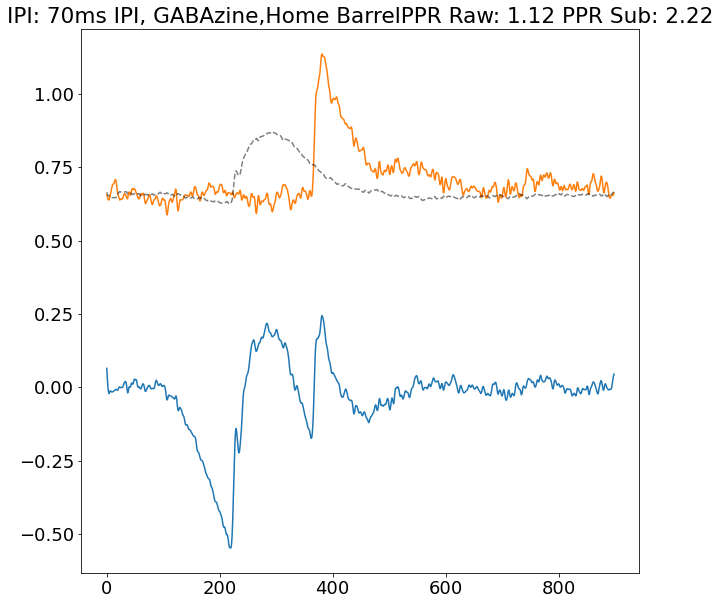

Date 9-27-24 Slice 1 Location 2 Recording 3
IPI 70 Drug GABAzine ROI 2 stim_current 50
Trace Sub Dist: 0.029687765254473662


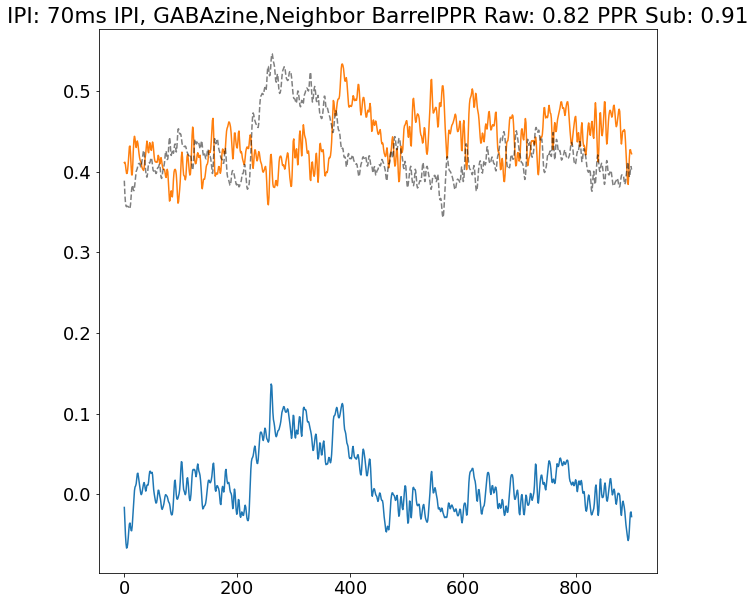

Date 9-27-24 Slice 1 Location 3 Recording 5
IPI 70 Drug GABAzine ROI 1 stim_current 20
Trace Sub Dist: 0.02767794994623959


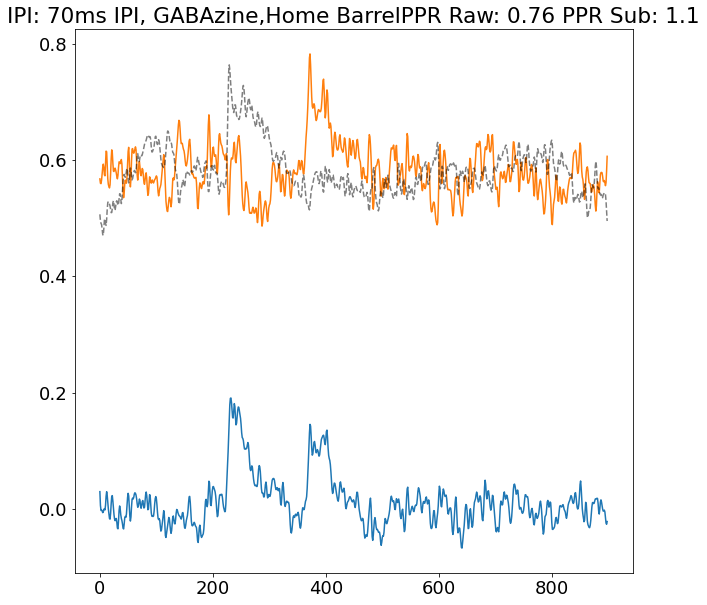

Date 9-27-24 Slice 1 Location 3 Recording 5
IPI 70 Drug GABAzine ROI 2 stim_current 20
Trace Sub Dist: 0.03934847992327289


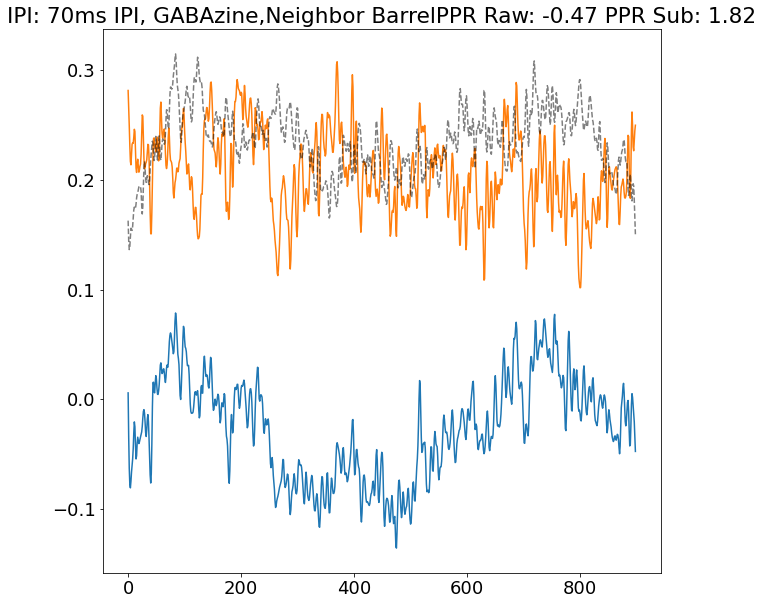

Missing PPR or Control trace for IPI 70 Drug GABAzine ROI 1
Date 9-27-24 Slice 2 Location 2 Recording 4
IPI 70 Drug GABAzine ROI 1 stim_current 20
PPR Trace


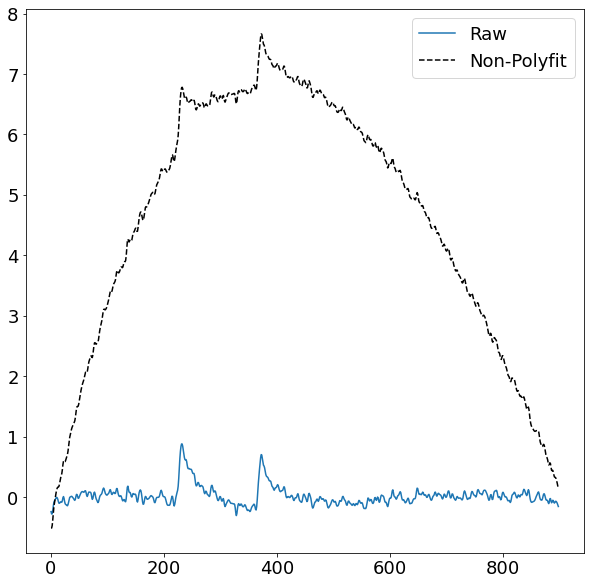

Missing PPR or Control trace for IPI 70 Drug GABAzine ROI 2
Date 9-27-24 Slice 2 Location 2 Recording 4
IPI 70 Drug GABAzine ROI 2 stim_current 20
PPR Trace


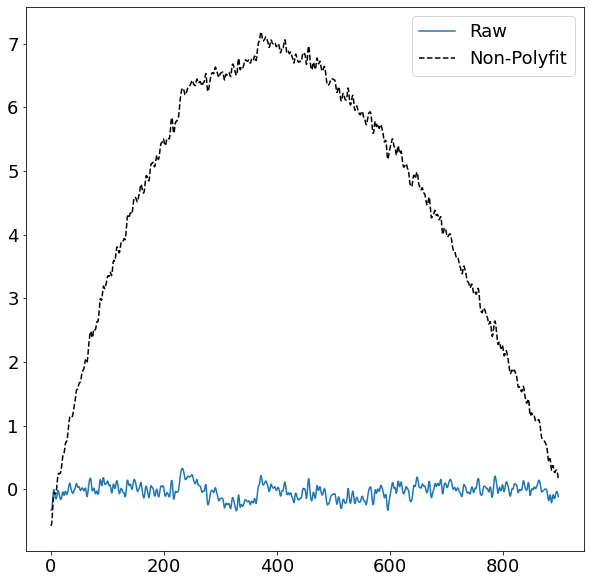

In [53]:
# for each ROI, load traces and perform summation decomposition by 
# subtracting the control trace from the paired-pulse trace.
# display the traces and the maxAmp arrays for each pulse
ppr = {}


for ipi in export_df['ipi'].unique():
    ipi_df = export_df[export_df['ipi'] == ipi]
    for drug in ipi_df['drug'].unique():
        drug_df = ipi_df[ipi_df['drug'] == drug]
        for slic in drug_df['Slice'].unique():
            slic_df = drug_df[drug_df['Slice'] == slic]
            for loc in slic_df['Location'].unique():
                loc_df = slic_df[slic_df['Location'] == loc]
                for roi in loc_df['ROI'].unique():
                    roi_df = loc_df[loc_df['ROI'] == roi]
                    roi_idx = 'ROI' + str(roi)

                    rec_id = roi_df['Recording'].values[0]
                    
                    ppr_row = roi_df[roi_df['num_pulses'].str.contains('PPR')]
                    control_row = roi_df[roi_df['num_pulses'].str.contains('ontrol')]

                    # load traces
                    if ppr_row.empty or control_row.empty:
                        # show whichever trace is not missing
                        print("Missing PPR or Control trace for IPI", ipi, "Drug", drug, "ROI", roi)
                        if ppr_row.empty:
                            control_trace = read_dat_trace_file(control_row['trace'].values[0])
                            control_trace_non_polyfit = read_dat_trace_file(control_row['trace_non_polyfit'].values[0])
                            print("Date", control_row['Date'].values[0], "Slice", control_row['Slice'].values[0], "Location", control_row['Location'].values[0], "Recording", control_row['Recording'].values[0])
                            print("IPI", ipi, "Drug", drug, "ROI", roi, "stim_current", control_row['Stim_Current'].values[0])
                            print("Control Trace")
                            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
                            roi_idx = 'ROI' + str(roi)
                            #ax.plot(control_trace['Pt'], control_trace[roi_idx], label='Raw')
                            ax.plot(control_trace['Pt'], control_trace_non_polyfit[roi_idx], 'k--', label='Non-Polyfit')
                            ax.legend()
                            plt.show()
                        else:
                            ppr_trace = read_dat_trace_file(ppr_row['trace'].values[0])
                            ppr_trace_non_polyfit = read_dat_trace_file(ppr_row['trace_non_polyfit'].values[0])
                            print("Date", ppr_row['Date'].values[0], "Slice", ppr_row['Slice'].values[0], "Location", ppr_row['Location'].values[0], "Recording", ppr_row['Recording'].values[0])
                            print("IPI", ipi, "Drug", drug, "ROI", roi, "stim_current", ppr_row['Stim_Current'].values[0])
                            print("PPR Trace")
                            fig, ax = plt.subplots(1, 1, figsize=(10, 10))
                            roi_idx = 'ROI' + str(roi)
                            ax.plot(ppr_trace['Pt'], ppr_trace[roi_idx], label='Raw')
                            ax.plot(ppr_trace['Pt'], ppr_trace_non_polyfit[roi_idx], 'k--', label='Non-Polyfit')
                            ax.legend()
                            plt.show()

                        continue
                    ppr_trace = read_dat_trace_file(ppr_row['trace'].values[0])
                    ppr_trace_non_polyfit = read_dat_trace_file(ppr_row['trace_non_polyfit'].values[0])
                    control_trace = read_dat_trace_file(control_row['trace'].values[0])
                    control_trace_non_polyfit = read_dat_trace_file(control_row['trace_non_polyfit'].values[0])

                    # calculate first and second maxAmp of raw trace in measure windows
                    second_pulse_measure_window = [356, 450]
                    first_pulse_measure_window = [116, 350]

                    # reapply baseline correction to raw trace
                    bc = BaselineCorrection(ppr_trace, exclusion_windows=[(116, 316), (356, 556)])
                    ret = bc.fit_baseline('ROI1')

                    ppr_trace['ROI1'] = ppr_trace['Corrected_ROI1']




                    # normalize the control traces to the max amp of the ppr traces in the first measure window
                    control_trace_non_polyfit = control_trace_non_polyfit * (ppr_trace_non_polyfit[ppr_trace_non_polyfit['Pt'] < 356].max() / 
                                                                            control_trace_non_polyfit[control_trace_non_polyfit['Pt'] < 356].max())
                    control_trace = control_trace * (ppr_trace[ppr_trace['Pt'] < 356].max() / control_trace[control_trace['Pt'] < 356].max())

                    trace_sub = ppr_trace_non_polyfit[roi_idx] - control_trace_non_polyfit[roi_idx]

                    print("Date", ppr_row['Date'].values[0], "Slice", ppr_row['Slice'].values[0], "Location", ppr_row['Location'].values[0], "Recording", ppr_row['Recording'].values[0])
                    print("IPI", ipi, "Drug", drug, "ROI", roi, "stim_current", ppr_row['Stim_Current'].values[0])

                    # calculate dist from zero of subtracted trace before second stim
                    trace_sub_dist = trace_sub[(trace_sub.index < 356) | (trace_sub.index > 550)].abs().mean()
                    print('Trace Sub Dist: ' + str(trace_sub_dist))
                    if trace_sub_dist > 1:
                        print('Warning: trace_sub_dist is greater than 1: ' + str(trace_sub_dist))
                        continue

                    # calculate maxAmp of subtracted trace in measure window (356 - 450)
                    trace_sub_max = trace_sub[(trace_sub.index > 356) & (trace_sub.index < 450)].max()

                    pulse1_raw_maxamp = ppr_trace[(ppr_trace.index > first_pulse_measure_window[0]) & 
                                                (ppr_trace.index < first_pulse_measure_window[1])][roi_idx].max()
                    pulse2_raw_maxamp = ppr_trace[(ppr_trace.index > second_pulse_measure_window[0]) &
                                                (ppr_trace.index < second_pulse_measure_window[1])][roi_idx].max()

                    ppr_raw = pulse2_raw_maxamp / pulse1_raw_maxamp
                    ppr_sub = trace_sub_max / pulse1_raw_maxamp

                    # show both traces and their subtraction (PPR - Control)
                    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
                    roi_idx = 'ROI' + str(roi)
                    ax.plot(ppr_trace['Pt'], ppr_trace[roi_idx], label='Raw')
                    #ax.plot(control_trace['Pt'], control_trace[roi_idx], 'k--', label='Control', alpha=0.5)
                    ax.plot(ppr_trace['Pt'], 
                                trace_sub + np.max(control_trace[roi_idx]) * 3, 
                                label='Raw - Control')
                    ax.plot(ppr_trace['Pt'], 
                                control_trace[roi_idx] + np.max(control_trace[roi_idx]) * 3, 'k--', 
                                alpha=0.5)
                    #ax.legend()
                    # annotate with ppr_raw, ppr_sub, and trace_sub_dist
                    #ax.text(0.1, 0.3, 'PPR Raw: ' + str(round(ppr_raw,2)), transform=ax.transAxes)
                    #ax.text(0.1, 0.9, 'PPR Sub: ' + str(round(ppr_sub,2)), transform=ax.transAxes)
                    ax.set_title('IPI: ' + str(ipi) + 'ms IPI, ' + drug + ',' + ("Home" if roi == 1 else "Neighbor") + " Barrel" + \
                        'PPR Raw: ' + str(round(ppr_raw,2)) + ' PPR Sub: ' + str(round(ppr_sub,2))
                        )
                    # ax.text(0.1, 0.7, 'Trace Sub Dist: ' + str(trace_sub_dist)[:6], transform=ax.transAxes)
                    if slic == 2 and rec_id in [2, 5]:
                        plt.savefig("P:/John/F31 resubmission/figures/input/" + str(ipi) + "ms_" + drug + "_ROI" + str(roi) + ".png")
                    plt.show()

                    if ipi not in ppr:
                        ppr[ipi] = {}
                    if drug not in ppr[ipi]:
                        ppr[ipi][drug] = {}
                    if roi not in ppr[ipi][drug]:
                        ppr[ipi][drug][roi] = {}
                    ppr[ipi][drug][roi]['ppr_raw'] = ppr_raw
                    ppr[ipi][drug][roi]['ppr_sub'] = ppr_sub

<ipython-input-58-d843bb3c8bb0>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_xticklabels(['ACSF', '+GABAzine'])


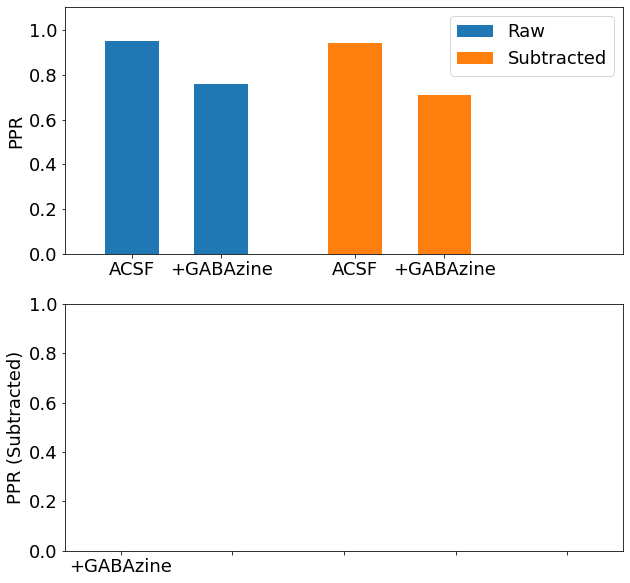

In [58]:
# bar plot of PPR Raw and PPR Sub going from ACSF to +GABAzine
# hard-code this data in for now to get the bar plot

# set matplotlib defaults for font size
rcParams.update({'font.size': 18})

fig, ax = plt.subplots(2,1, figsize=(10, 10))
ppr_raw = [0.95, 0.76]
ppr_sub = [0.94, 0.71]

ppr_raw = np.array(ppr_raw)
ppr_sub = np.array(ppr_sub)
ax[0].bar([-.2, .2], ppr_raw, color='tab:blue', label='Raw', width=0.24)
ax[0].bar([1-.2, 1.2], ppr_sub, color='tab:orange', label='Subtracted', width=0.24)
ax[0].set_xticks([-.2, .2, 1-.2, 1.2])
ax[0].set_ylabel('PPR')
ax[1].set_ylabel('PPR (Subtracted)')
ax[0].set_xlim(-0.5, 2)
ax[1].set_xlim(-.5, .5)
ax[0].set_ylim(0, 1.1)
ax[1].set_ylim(0, 1)

ax[0].set_xticklabels(['ACSF', '+GABAzine', 'ACSF', '+GABAzine'])
ax[1].set_xticklabels(['ACSF', '+GABAzine'])
ax[0].legend()
plt.show()